# <center> Ramas dataset 

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import torchaudio
import torch
import matplotlib.pyplot as plt
from pydub import AudioSegment
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Описание

In [4]:
category_files = os.listdir('Ramas(audio)/Annotations_by_emotions')
category_files

['data_Angry.csv',
 'data_Disgusted.csv',
 'data_Domination.csv',
 'data_Happy.csv',
 'data_Neutral.csv',
 'data_Sad.csv',
 'data_Scared.csv',
 'data_Shame.csv',
 'data_Submission.csv',
 'data_Surprised.csv',
 'data_Tiredness.csv']

Всего 11 категорий, соответствующих различным эмоциям. Рассмотрим статистику по категориям.

### Angry category

In [5]:
data_angry = pd.read_csv('Ramas(audio)/Annotations_by_emotions/data_Angry.csv')
data_angry.head()

,ID,File,Start,End
0,1,10dec_D11_1,123.801,143.728
1,1,10dec_D11_1,210.220,257.280
2,1,10dec_D31_1,20.981,29.468
3,1,10dec_D41_1,21.083,24.517
4,1,10dec_D41_1,26.379,31.611


In [6]:
data_angry.shape

(1561, 4)

In [7]:
stats_angry = data_angry.End - data_angry.Start

In [8]:
stats_angry.describe()

count    1561.000000
mean       10.421540
std        10.619133
min         0.007000
25%         3.340000
50%         6.113000
75%        12.954000
max        60.090000
dtype: float64

### Остальные категории

In [9]:
for cat in category_files:
    data = pd.read_csv('Ramas(audio)/Annotations_by_emotions/' + cat)
    stats_data = data.End - data.Start
    print()
    print(cat[5:-4])
    print(stats_data.describe(), end='\n')


Angry
count    1561.000000
mean       10.421540
std        10.619133
min         0.007000
25%         3.340000
50%         6.113000
75%        12.954000
max        60.090000
dtype: float64

Disgusted
count    1152.000000
mean       10.703730
std        10.906867
min         0.020000
25%         3.288250
50%         6.424000
75%        14.727500
max        62.457000
dtype: float64

Domination
count    2400.000000
mean       25.914166
std        18.618666
min         0.002000
25%         7.212500
50%        27.035000
75%        39.740500
max        91.960000
dtype: float64

Happy
count    2618.000000
mean        9.416040
std        10.521548
min         0.004000
25%         2.910000
50%         5.373000
75%        11.004250
max        76.147000
dtype: float64

Neutral
count    1269.000000
mean       24.581823
std        32.358076
min         0.002000
25%         4.910000
50%        13.060000
75%        35.266000
max       382.938000
dtype: float64

Sad
count    1022.000000
mean       13

По некоторым категориям, вроде `Tiredness`, у нас достаточно мало объектов, однако по основным категориям больше 1000 объектов, этого уже достаточно для моделей.

In [10]:
x, sr = librosa.load('RAMAS(audio)/Audio/10dec_D11_1_mic.wav')

In [11]:
x.shape

(7946240,)

In [12]:
sr

22050

In [13]:
x, sr = librosa.load('RAMAS(audio)/Audio/10dec_D42_1_mic.wav')

In [14]:
x.shape

(649472,)

In [15]:
sr

22050

In [16]:
audio, sample_rate = x, sr

In [68]:
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
mfccsscaled = np.mean(mfccs.T,axis=0)


In [69]:
mfccsscaled.shape

(128,)

## Сборка

In [9]:
class DataLoader:
    
    def __init__(self, category_filenames, audio_path, table_prefix, sample_rate):
        self.table_prefix = table_prefix
        self.category_filenames = category_filenames
        self.audio_path = audio_path
        self.sample_rate = sample_rate
        
    def make_dataset(self):
        train_test_data = []
        c = 0
        for category in self.category_filenames:
            data = pd.read_csv(self.table_prefix + category)
            values = data.values
            for i in range(values.shape[0]):
                ind, name, start, end = values[i]
                try:
                    file = AudioSegment.from_file(self.audio_path + name + "_mic.wav")
                except:
                    c += 1
                    continue
                try:
                    audio = np.array(file[start * 1000 : end * 1000].get_array_of_samples()).astype('float')
                    mfccs = librosa.feature.mfcc(y=audio, sr=self.sample_rate, n_mfcc=128)
                    mfccsscaled = np.mean(mfccs.T,axis=0)
                    train_test_data.append([category, mfccsscaled])
                except:
                    c += 1
        print(f'Lost: {c}')
        return train_test_data

In [20]:
dl = DataLoader(category_files, "RAMAS(audio)/Audio/", "RAMAS(audio)/Annotations_by_emotions/", 22050)

In [21]:
ds = dl.make_dataset()

Lost: 12064


In [22]:
len(ds)

3704

In [26]:
ds = np.array(ds)

In [27]:
ds.shape

(3704, 2)

In [30]:
pd.Series(ds[:, 0]).value_counts()

data_Happy.csv         638
data_Domination.csv    561
data_Neutral.csv       456
data_Submission.csv    437
data_Surprised.csv     390
data_Angry.csv         352
data_Disgusted.csv     292
data_Scared.csv        292
data_Sad.csv           221
data_Shame.csv          47
data_Tiredness.csv      18
dtype: int64

Мы каким-то образом потеряли 75% выборки. Попробуем построить модель с тем, что есть

## Модель

In [40]:
X = ds[:, 1]

In [41]:
y = ds[:, 0]

In [46]:
y = pd.get_dummies(y).values

In [47]:
X.shape, y.shape

((3704,), (3704, 11))

In [60]:
X_df = pd.DataFrame(np.array(list(map(lambda x: x.astype('float'), X))))

In [61]:
y_df = pd.DataFrame(y)

In [63]:
y_df.columns = list(map(lambda x: 'y' + str(x), list(range(11))))

In [65]:
y_df.head()

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [66]:
data = pd.concat([X_df, y_df], axis=1, join="inner")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,782.593805,125.750045,-7.096012,30.291876,-0.623040,18.035505,-6.152137,-1.018289,2.531784,-8.745806,...,0,0,0,0,0,0,0,0,0,0
1,741.856962,108.594665,-1.118418,27.996197,11.538417,22.573374,-1.725687,0.121963,6.591717,-7.095285,...,0,0,0,0,0,0,0,0,0,0
2,634.575656,120.989468,46.548484,32.590693,0.425295,17.662792,-2.438896,8.921270,1.695513,-3.892302,...,0,0,0,0,0,0,0,0,0,0
3,700.463525,113.865510,4.920722,14.854562,-3.228789,10.422334,-15.603181,3.501256,-3.101876,-3.035515,...,0,0,0,0,0,0,0,0,0,0
4,705.055377,117.656892,12.225516,11.308633,7.450487,16.785764,-13.225361,-0.508475,-0.539966,-8.581552,...,0,0,0,0,0,0,0,0,0,0


In [67]:
data = data.sample(frac=1)

In [68]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
591,384.129371,85.977938,40.818019,28.741837,7.832749,20.175130,10.109065,8.157295,3.525333,6.832565,...,1,0,0,0,0,0,0,0,0,0
2608,550.057781,74.398509,37.835662,23.751557,2.801084,13.353396,4.986113,3.572924,6.381383,4.266097,...,0,0,0,0,0,1,0,0,0,0
3577,686.089516,96.164423,16.735599,27.800913,-6.844259,12.922735,-5.041590,2.088965,-5.520138,-1.033384,...,0,0,0,0,0,0,0,0,1,0
558,562.667364,68.370049,12.705847,31.576763,12.842649,10.848686,0.078092,8.757463,2.445527,1.885409,...,1,0,0,0,0,0,0,0,0,0
387,641.729316,98.827580,8.722678,43.513372,11.815128,32.351787,3.589162,8.736470,-0.765453,3.760414,...,1,0,0,0,0,0,0,0,0,0


In [69]:
Train_data = data[:3200]
Test_data = data[3200:]

In [70]:
X_train = Train_data[list(range(128))]
X_test = Test_data[list(range(128))]
X_train.shape, X_test.shape

((3200, 128), (504, 128))

In [71]:
X_train = X_train.values.reshape(3200, 128, 1)
X_test = X_test.values.reshape(504, 128, 1)
X_train.shape, X_test.shape

((3200, 128, 1), (504, 128, 1))

In [72]:
y_train = Train_data[y_df.columns]
y_test = Test_data[y_df.columns]

In [75]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same',
                 input_shape=(128,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(11))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 128, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           8

In [77]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [78]:
cnnhistory=model.fit(X_train, y_train, batch_size=16, epochs=700, validation_data=(X_test, y_test))

Epoch 1/700
200/200 [==============================] - 9s 37ms/step - loss: 2.4772 - accuracy: 0.1231 - val_loss: 2.2360 - val_accuracy: 0.1329
Epoch 2/700
200/200 [==============================] - 6s 28ms/step - loss: 2.2749 - accuracy: 0.1506 - val_loss: 2.2248 - val_accuracy: 0.1627
Epoch 3/700
200/200 [==============================] - 5s 27ms/step - loss: 2.2447 - accuracy: 0.1560 - val_loss: 2.2140 - val_accuracy: 0.1964
Epoch 4/700
200/200 [==============================] - 5s 27ms/step - loss: 2.2346 - accuracy: 0.1633 - val_loss: 2.2125 - val_accuracy: 0.1726
Epoch 5/700
200/200 [==============================] - 6s 30ms/step - loss: 2.2390 - accuracy: 0.1542 - val_loss: 2.1952 - val_accuracy: 0.1607
Epoch 6/700
200/200 [==============================] - 6s 28ms/step - loss: 2.2093 - accuracy: 0.1610 - val_loss: 2.1850 - val_accuracy: 0.1925
Epoch 7/700
200/200 [==============================] - 5s 27ms/step - loss: 2.1879 - accuracy: 0.1812 - val_loss: 2.1716 - val_accuracy:

200/200 [==============================] - 5s 24ms/step - loss: 1.6037 - accuracy: 0.4328 - val_loss: 1.7765 - val_accuracy: 0.3730
Epoch 114/700
200/200 [==============================] - 5s 24ms/step - loss: 1.5733 - accuracy: 0.4665 - val_loss: 1.7677 - val_accuracy: 0.3750
Epoch 115/700
200/200 [==============================] - 5s 24ms/step - loss: 1.6153 - accuracy: 0.4344 - val_loss: 1.8092 - val_accuracy: 0.3790
Epoch 116/700
200/200 [==============================] - 5s 24ms/step - loss: 1.5991 - accuracy: 0.4478 - val_loss: 1.8028 - val_accuracy: 0.3611
Epoch 117/700
200/200 [==============================] - 5s 24ms/step - loss: 1.5784 - accuracy: 0.4460 - val_loss: 1.7798 - val_accuracy: 0.3869
Epoch 118/700
200/200 [==============================] - 5s 24ms/step - loss: 1.5879 - accuracy: 0.4450 - val_loss: 1.7916 - val_accuracy: 0.3770
Epoch 119/700
200/200 [==============================] - 5s 24ms/step - loss: 1.5464 - accuracy: 0.4648 - val_loss: 1.8016 - val_accuracy:

200/200 [==============================] - 6s 28ms/step - loss: 1.2993 - accuracy: 0.5304 - val_loss: 1.7237 - val_accuracy: 0.4008
Epoch 226/700
200/200 [==============================] - 6s 28ms/step - loss: 1.2801 - accuracy: 0.5381 - val_loss: 1.6970 - val_accuracy: 0.4206
Epoch 227/700
200/200 [==============================] - 6s 28ms/step - loss: 1.2910 - accuracy: 0.5435 - val_loss: 1.6963 - val_accuracy: 0.4444
Epoch 228/700
200/200 [==============================] - 6s 28ms/step - loss: 1.2664 - accuracy: 0.5704 - val_loss: 1.7397 - val_accuracy: 0.4107
Epoch 229/700
200/200 [==============================] - 6s 28ms/step - loss: 1.2677 - accuracy: 0.5641 - val_loss: 1.7441 - val_accuracy: 0.4028
Epoch 230/700
200/200 [==============================] - 6s 28ms/step - loss: 1.2737 - accuracy: 0.5547 - val_loss: 1.7174 - val_accuracy: 0.4147
Epoch 231/700
200/200 [==============================] - 6s 28ms/step - loss: 1.2856 - accuracy: 0.5572 - val_loss: 1.7201 - val_accuracy:

200/200 [==============================] - 5s 26ms/step - loss: 1.0250 - accuracy: 0.6420 - val_loss: 1.7416 - val_accuracy: 0.4187
Epoch 338/700
200/200 [==============================] - 5s 26ms/step - loss: 1.0386 - accuracy: 0.6396 - val_loss: 1.7358 - val_accuracy: 0.3988
Epoch 339/700
200/200 [==============================] - 5s 26ms/step - loss: 1.0413 - accuracy: 0.6475 - val_loss: 1.7571 - val_accuracy: 0.4107
Epoch 340/700
200/200 [==============================] - 5s 26ms/step - loss: 1.0426 - accuracy: 0.6267 - val_loss: 1.7878 - val_accuracy: 0.4107
Epoch 341/700
200/200 [==============================] - 5s 26ms/step - loss: 1.0246 - accuracy: 0.6401 - val_loss: 1.7848 - val_accuracy: 0.4028
Epoch 342/700
200/200 [==============================] - 5s 26ms/step - loss: 1.0234 - accuracy: 0.6304 - val_loss: 1.7797 - val_accuracy: 0.4067
Epoch 343/700
200/200 [==============================] - 5s 26ms/step - loss: 1.0101 - accuracy: 0.6433 - val_loss: 1.7479 - val_accuracy:

200/200 [==============================] - 5s 26ms/step - loss: 0.8827 - accuracy: 0.6760 - val_loss: 1.8916 - val_accuracy: 0.3968
Epoch 450/700
200/200 [==============================] - 5s 26ms/step - loss: 0.8781 - accuracy: 0.6833 - val_loss: 1.8626 - val_accuracy: 0.4127
Epoch 451/700
200/200 [==============================] - 5s 26ms/step - loss: 0.8373 - accuracy: 0.6929 - val_loss: 1.8174 - val_accuracy: 0.4286
Epoch 452/700
200/200 [==============================] - 5s 26ms/step - loss: 0.8576 - accuracy: 0.6999 - val_loss: 1.8835 - val_accuracy: 0.3988
Epoch 453/700
200/200 [==============================] - 5s 26ms/step - loss: 0.8610 - accuracy: 0.6802 - val_loss: 1.8416 - val_accuracy: 0.4226
Epoch 454/700
200/200 [==============================] - 5s 26ms/step - loss: 0.8519 - accuracy: 0.6959 - val_loss: 1.8361 - val_accuracy: 0.4167
Epoch 455/700
200/200 [==============================] - 5s 26ms/step - loss: 0.8081 - accuracy: 0.7045 - val_loss: 1.8558 - val_accuracy:

200/200 [==============================] - 5s 26ms/step - loss: 0.7856 - accuracy: 0.7094 - val_loss: 1.9984 - val_accuracy: 0.3988
Epoch 506/700
200/200 [==============================] - 5s 25ms/step - loss: 0.7852 - accuracy: 0.7016 - val_loss: 1.9095 - val_accuracy: 0.4325
Epoch 507/700
200/200 [==============================] - 5s 25ms/step - loss: 0.7912 - accuracy: 0.7046 - val_loss: 2.0089 - val_accuracy: 0.4067
Epoch 508/700
200/200 [==============================] - 5s 25ms/step - loss: 0.7816 - accuracy: 0.7219 - val_loss: 1.8873 - val_accuracy: 0.4266
Epoch 509/700
200/200 [==============================] - 5s 25ms/step - loss: 0.7712 - accuracy: 0.7086 - val_loss: 1.9593 - val_accuracy: 0.4028
Epoch 510/700
200/200 [==============================] - 5s 25ms/step - loss: 0.7818 - accuracy: 0.7118 - val_loss: 1.9632 - val_accuracy: 0.4206
Epoch 511/700
200/200 [==============================] - 5s 25ms/step - loss: 0.7464 - accuracy: 0.7216 - val_loss: 1.9496 - val_accuracy:

200/200 [==============================] - 5s 26ms/step - loss: 0.6457 - accuracy: 0.7528 - val_loss: 2.1424 - val_accuracy: 0.4127
Epoch 618/700
200/200 [==============================] - 5s 26ms/step - loss: 0.6484 - accuracy: 0.7479 - val_loss: 2.0925 - val_accuracy: 0.4405
Epoch 619/700
200/200 [==============================] - 5s 26ms/step - loss: 0.6313 - accuracy: 0.7591 - val_loss: 2.1025 - val_accuracy: 0.4087
Epoch 620/700
200/200 [==============================] - 5s 26ms/step - loss: 0.6334 - accuracy: 0.7744 - val_loss: 2.1010 - val_accuracy: 0.4147
Epoch 621/700
200/200 [==============================] - 5s 26ms/step - loss: 0.6462 - accuracy: 0.7529 - val_loss: 2.1079 - val_accuracy: 0.4206
Epoch 622/700
200/200 [==============================] - 5s 26ms/step - loss: 0.6511 - accuracy: 0.7502 - val_loss: 2.0734 - val_accuracy: 0.4187
Epoch 623/700
200/200 [==============================] - 5s 26ms/step - loss: 0.6561 - accuracy: 0.7379 - val_loss: 2.1070 - val_accuracy:

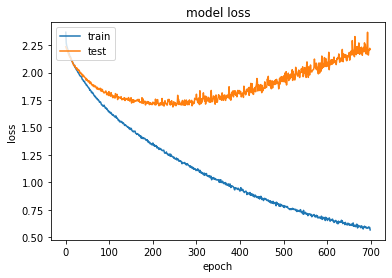

In [79]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

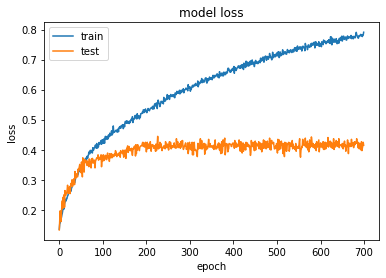

In [80]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Разбираемся с проблемами

In [9]:
example = data_angry.values[3]
example

array([1, '10dec_D41_1', 21.083000000000002, 24.517], dtype=object)

In [10]:
file = AudioSegment.from_file("RAMAS(audio)/Audio/" + example[1] + "_mic.wav")

In [11]:
audio = np.array(file[example[2] * 1000 : example[3] * 1000].get_array_of_samples()).astype('float')

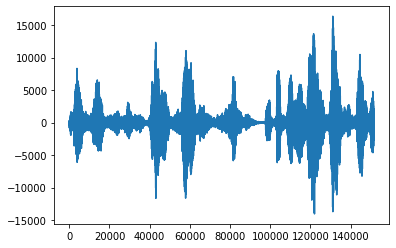

In [12]:
plt.plot(audio)

In [13]:
len(file)

31626

In [14]:
np.array(file[example[2] * 1000 : example[3] * 1000].get_array_of_samples()).shape

(151439,)

In [15]:
mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13),axis=0)

NameError: name 'sample_rate' is not defined

In [ ]:
mfccs.shape

In [153]:
sample_rate

22050

Лучше выбирать другое значение `mfcc`, например 13

In [131]:
x, sr = librosa.load("RAMAS(audio)/Audio/" + example[1] + "_mic.wav")

In [133]:
x.shape

(697344,)

Тут какая-то потеря информации при использовании audio segment. Перепишем data loader.

In [17]:
def get_melspectrogram_db(file_path, sr=22050, n_fft=2048, hop_length=512, n_mels=13, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [18]:
class DataLoader1:
    
    def __init__(self, category_filenames, audio_path, table_prefix, sample_rate):
        self.table_prefix = table_prefix
        self.category_filenames = category_filenames
        self.audio_path = audio_path
        self.sample_rate = sample_rate
        
    def make_dataset(self):
        train_test_data = []
        c = 0
        d = 0
        for category in self.category_filenames:
            data = pd.read_csv(self.table_prefix + category)
            values = data.values
            for i in range(values.shape[0]):
                ind, name, start, end = values[i]
                if end - start > 3:
                    try:
                        file = AudioSegment.from_file(self.audio_path + name + '_mic.wav')
                    except:
                        c += 1
                        continue
                    new_file = file[start * 1000 : end * 1000]
                    new_file.export('test.wav', format='wav')
                    try:
                        mfccs = get_melspectrogram_db('test.wav')
                        train_test_data.append([category, mfccs])
                    except:
                        d += 1
                        continue
                if i % 100 == 0:
                    print("Current: ", i)
            print(category)
    #                 print(mfccs.shape)
        print(f'Lost: {c}, errors: {d}')
        return train_test_data

In [19]:
dl = DataLoader1(category_files, "RAMAS(audio)/Audio/", "RAMAS(audio)/Annotations_by_emotions/", 22050)

In [20]:
ds = dl.make_dataset()

Current:  0
Current:  100
Current:  200
Current:  400
Current:  500
Current:  600
Current:  700
Current:  800
Current:  900
Current:  1000
Current:  1100
Current:  1200
Current:  1300
Current:  1400
Current:  1500
data_Angry.csv
Current:  0
Current:  100
Current:  200
Current:  300
Current:  400
Current:  500
Current:  600
Current:  700
Current:  800
Current:  900
Current:  1000
Current:  1100
data_Disgusted.csv
Current:  0
Current:  100
Current:  200
Current:  300
Current:  400
Current:  500
Current:  600
Current:  700
Current:  800
Current:  900
Current:  1100
Current:  1200
Current:  1400
Current:  1500
Current:  1600
Current:  1700
Current:  1800
Current:  1900
Current:  2000
Current:  2100
Current:  2200
Current:  2300
data_Domination.csv
Current:  0
Current:  100
Current:  200
Current:  300
Current:  400
Current:  500
Current:  600
Current:  700
Current:  800
Current:  900
Current:  1000
Current:  1100
Current:  1200
Current:  1300
Current:  1400
Current:  1500
Current:  1600
Cur

In [21]:
len(ds)

12399

In [22]:
ds[0][1].shape

(13, 216)

In [58]:
import json

In [23]:
dfdf = pd.DataFrame(ds)

In [24]:
dfdf.head()

,0,1
0,data_Angry.csv,"[[4.540872, 4.747926, 5.1777024, 6.526989, 6.5..."
1,data_Angry.csv,"[[-7.098838, -6.5053678, -7.713932, -8.140531,..."
2,data_Angry.csv,"[[-11.991674, -13.944952, -18.29658, -18.32674..."
3,data_Angry.csv,"[[-13.065662, -13.430577, -10.778725, -5.56246..."
4,data_Angry.csv,"[[-8.406487, -1.1172584, 6.307428, 8.425748, 6..."


In [25]:
data_ramas_np = np.array(ds)

In [29]:
data_ramas_np[0, 1].shape

(13, 216)

In [30]:
np.save('data_ramas_numpy_13_216.npy', data_ramas_np)

In [31]:
with open('data_ramas_numpy_13_216.npy', 'rb') as f:
    a = np.load(f, allow_pickle=True)

In [19]:
res = get_melspectrogram_db('test.wav')

In [20]:
res.shape

(13, 216)

In [32]:
a

array([['data_Angry.csv',
        array([[  4.540872 ,   4.747926 ,   5.1777024, ...,  13.815523 ,
         10.333677 ,  13.135548 ],
       [  8.823043 ,   8.296895 ,   9.382535 , ...,  20.119097 ,
         17.015358 ,  17.99496  ],
       [  9.111742 ,   8.407463 ,   6.838833 , ...,   0.239422 ,
          1.8814344,   4.2713685],
       ...,
       [-34.916187 , -33.35733  , -29.940577 , ..., -14.748358 ,
        -12.38315  , -13.810341 ],
       [-39.58647  , -43.310165 , -45.446175 , ..., -18.303253 ,
        -15.481214 , -16.304958 ],
       [-38.180733 , -41.574516 , -45.316883 , ..., -22.12142  ,
        -22.96006  , -22.276413 ]], dtype=float32)],
       ['data_Angry.csv',
        array([[ -7.098838 ,  -6.5053678,  -7.713932 , ...,   2.300391 ,
          7.0834866,   7.7002907],
       [ -7.903755 ,  -2.9978552,  -1.8150294, ...,  -0.743976 ,
          2.2473986,   3.544095 ],
       [-14.413696 , -15.585791 , -14.912251 , ...,  -6.546685 ,
         -7.717809 ,  -7.4728165],
  